In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

# Load CIFAR-10 Dataset

### **CIFAR-10 Dataset**: It consists of 60,000 32x32 color images in 10 classes. Here, only the training set (X_train) is used, and the images are normalized to values between 0 and 1 to improve training stability.

In [2]:
# Load CIFAR-10 dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.cifar10.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

170498071/170498071 [==============================] - 2s 0us/step


# Build Generator

### The **generator** creates images that resemble real data from a random noise vector (input_dim=100), also called a latent space. It uses Convolutional Transpose layers (also known as deconvolution or upsampling layers) to gradually increase the spatial dimensions and convert the input noise into a 32x32 RGB image.

### ***Dense(256 * 8 * 8)***: The noise vector is transformed into a 256-channel feature map of shape 8x8.

### ***Reshape((8, 8, 256))***: Reshapes the dense output into a 3D feature map.

### ***Conv2DTranspose***: These layers upsample the feature maps to 16x16 and 32x32. Strides of 2 are used to double the spatial dimensions.

### ***Conv2D(3)***: The output is a 32x32 image with 3 channels (RGB). Tanh activation scales the pixel values to the range [-1, 1] to match the normalized CIFAR-10 images.

In [83]:
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embed and flatten the label input
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)

    # Combine noise and label embeddings
    combined_input = layers.Multiply()([noise_input, label_embedding])

    # Build the generator model
    x = layers.Dense(8 * 8 * 256)(combined_input)  # Start with a dense layer
    x = layers.Reshape((8, 8, 256))(x)  # Reshape to 8x8x256
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(x)  # Output: (16, 16, 128)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)  # Output: (32, 32, 64)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Additional layers for increased depth
    x = layers.Conv2DTranspose(32, (4, 4), strides=(1, 1), padding='same')(x)  # Output: (32, 32, 32)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    output_image = layers.Conv2DTranspose(3, (4, 4), padding='same', activation='tanh')(x)  # Output: (32, 32, 3)

    return tf.keras.Model([noise_input, label_input], output_image)

generator = build_generator()
generator.summary()


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_79 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_28 (Embedding)    (None, 1, 100)               1000      ['input_79[0][0]']            
                                                                                                  
 input_78 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 flatten_53 (Flatten)        (None, 100)                  0         ['embedding_28[0][0]']        
                                                                                           

# Building the Discriminator

### The **discriminator** tries to differientiate between real and generated (fake) images. It outputs a probability between 0 (fake) and 1 (real) using a sigmoid activation.

### ***Conv2D(64)***: Applies convolution with a kernel size of 5 and a stride of 2 to downsample the 32x32 image to 16x16.

### ***LeakyReLU(0.2)***: An activation function similar to ReLU, but with a small slope for negative values (alpha = 0.2). This prevents neurons from dying during training (which can happen with ReLU).

### ***Conv2D(128)***: Further downsampling the feature map from 16x16 to 8x8.

### ***Flatten()***: Converts the 3D feature maps into a 1D vector for the dense output layer.

### ***Dense(1, sigmoid)***: Produces a single output between 0 and 1 representing whether the input image is real or fake.

In [84]:
# Discriminator model (DCGAN)
def build_discriminator():
    image_input = layers.Input(shape=(32, 32, 3))  # Keep input size at 32x32
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embed and flatten the label input, then upscale to match the image size
    label_embedding = layers.Embedding(10, 32 * 32 * 3)(label_input)  # Adjust embedding size
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((32, 32, 3))(label_embedding)  # Match the new shape

    # Concatenate the image and label embedding
    combined_input = layers.Concatenate()([image_input, label_embedding])

    # Build the discriminator model
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same')(combined_input)  # Output: (16, 16, 64)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)  # Output: (8, 8, 128)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # Additional layers for increased depth
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)  # Output: (4, 4, 256)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)  # Output: (2, 2, 512)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  # Output: (1,)

    return tf.keras.Model([image_input, label_input], output)



# Call the discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_81 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 1, 3072)              30720     ['input_81[0][0]']            
                                                                                                  
 flatten_54 (Flatten)        (None, 3072)                 0         ['embedding_29[0][0]']        
                                                                                                  
 input_80 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                           

# Compile the Models

### The ***discriminator is compiled with the binary cross-entropy loss function since it performs binary classification*** (real vs. fake). The Adam optimizer is used to optimize the model.

In [85]:
# Build and compile models
generator = build_generator()  # Generator takes noise and label as input
discriminator = build_discriminator()  # Discriminator takes image and label as input

# Compile the discriminator with its loss function and optimizer
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False  # Freeze discriminator weights while training the GAN

# GAN Input: noise and label for the generator
noise_input = layers.Input(shape=(100,))
label_input = layers.Input(shape=(1,))

# Generate image from noise and label using the generator
generated_image = generator([noise_input, label_input])

# Discriminator evaluates the generated image and label
gan_output = discriminator([generated_image, label_input])

# GAN Model: connects the noise, label, generated image, and discriminator output
gan = tf.keras.Model([noise_input, label_input], gan_output)

# Compile the GAN with its optimizer and loss function
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')


# Train the function

### ***Noise Generation***: A batch of random noise vectors is generated and passed through the generator to produce fake images.

### ***Discriminator Training***: The discriminator is trained on both real and fake images. The real images are labeled as 0.9 (soft label, slightly less than 1 to prevent overconfidence), and the fake images are labeled as 0. Both are concatenated into one batch.

### ***Generator Training***: The generator tries to fool the discriminator, so it’s trained with the goal that the discriminator labels the generated images as real (1). During this phase, the discriminator's weights are frozen (discriminator.trainable = False).

### ***Loss Calculation***: After each epoch, the losses of both the discriminator (d_loss) and generator (g_loss) are printed.

In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training function for CGAN
def train(epochs, batch_size=128, save_interval=200, class_label=0):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    # Filter CIFAR-10 dataset for the specified class
    class_indices = np.where(Y_train == class_label)[0]
    X_train_class = X_train[class_indices]
    Y_train_class = Y_train[class_indices]

    for epoch in range(epochs):
        # Train the discriminator with real images
        idx = np.random.randint(0, X_train_class.shape[0], batch_size)
        real_images = X_train_class[idx]
        real_labels = Y_train_class[idx]  # Real labels corresponding to the class

        # Augment the real images
        augmented_images = next(datagen.flow(real_images, batch_size=batch_size))

        # Generate fake images from noise and labels
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_labels = np.full((batch_size, 1), class_label)  # Fake labels are the same class
        fake_images = generator.predict([noise, fake_labels])

        # Train discriminator on real images
        d_loss_real = discriminator.train_on_batch([augmented_images, real_labels], real)

        # Train discriminator on fake images
        d_loss_fake = discriminator.train_on_batch([fake_images, fake_labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator via GAN (with the goal of fooling the discriminator)
        g_loss = gan.train_on_batch([noise, fake_labels], real)

        # Check if we need to compute the Inception Score
        if epoch in [2000, 5000, 10000]:
            gen_images = generator.predict([noise, fake_labels])  # Generate images
            is_mean, is_std = calculate_inception_score(gen_images)
            print(f"Inception Score at epoch {epoch}: {is_mean} ± {is_std}")

        # Print the progress and save generated images at intervals
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, class_label=class_label)

# Image Generation Function

### This function generates images from random noise using the generator and plots them in a grid using Matplotlib. The images are rescaled from the [-1, 1] range (from the tanh activation) back to [0, 1] for viewing.

2/2 [==============================] - 0s 21ms/step
0 [D loss: 2.227121115004017, acc.: 75.78125%] [G loss: 11.475069046020508]
1/1 [==============================] - 0s 47ms/step


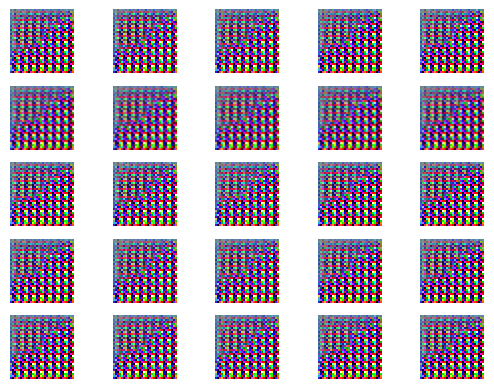

2/2 [==============================] - 0s 32ms/step
100 [D loss: 0.00011450790771050379, acc.: 100.0%] [G loss: 0.00738108903169632]
1/1 [==============================] - 0s 45ms/step


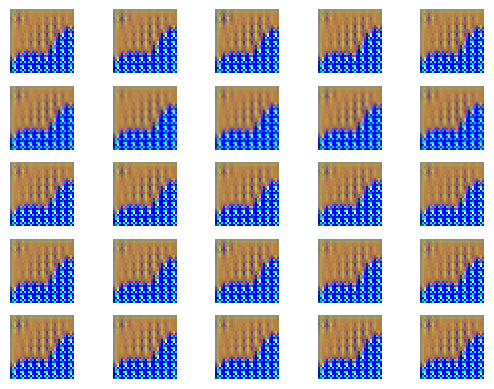

2/2 [==============================] - 0s 24ms/step
200 [D loss: 0.00027511541702551767, acc.: 100.0%] [G loss: 0.018118614330887794]
1/1 [==============================] - 0s 45ms/step


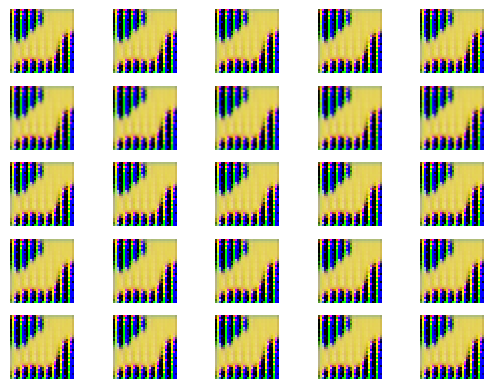

2/2 [==============================] - 0s 24ms/step
300 [D loss: 0.00042817791108973324, acc.: 100.0%] [G loss: 2.5174285838147625e-06]
1/1 [==============================] - 0s 43ms/step


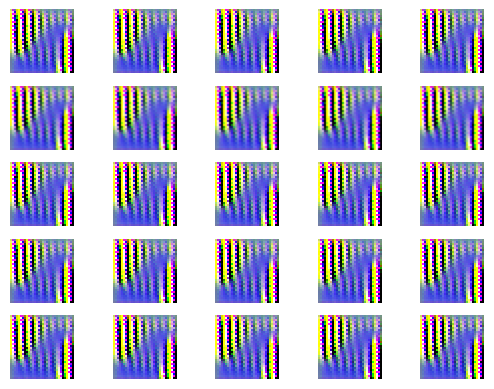

2/2 [==============================] - 0s 25ms/step
400 [D loss: 0.0022880687611177564, acc.: 100.0%] [G loss: 0.13089174032211304]
1/1 [==============================] - 0s 48ms/step


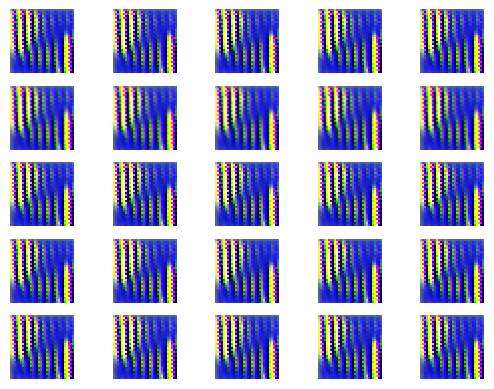

2/2 [==============================] - 0s 25ms/step
500 [D loss: 0.059659421211108565, acc.: 98.4375%] [G loss: 16.33563995361328]
1/1 [==============================] - 0s 45ms/step


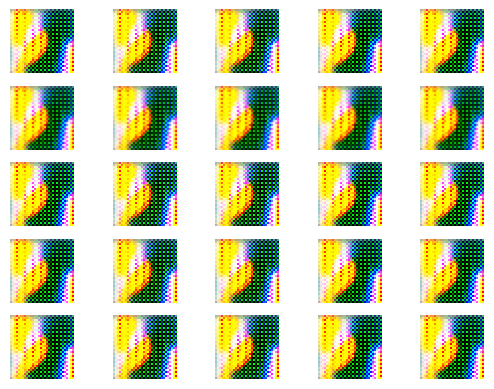

2/2 [==============================] - 0s 25ms/step
600 [D loss: 0.016341321635991335, acc.: 100.0%] [G loss: 2.509201765060425]
1/1 [==============================] - 0s 43ms/step


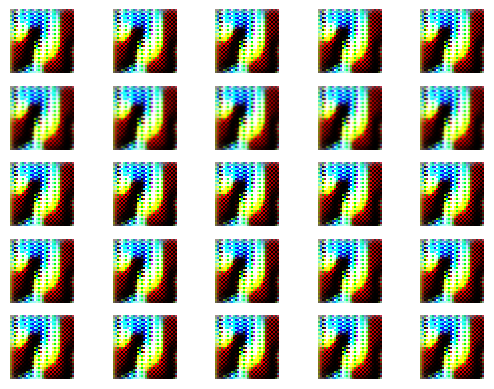

2/2 [==============================] - 0s 22ms/step
700 [D loss: 0.0007822323814252741, acc.: 100.0%] [G loss: 1.0039968162400825e-10]
1/1 [==============================] - 0s 43ms/step


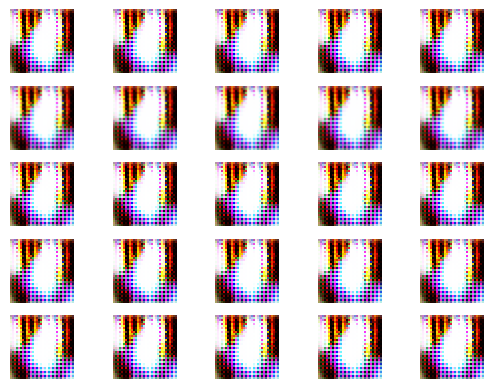

2/2 [==============================] - 0s 34ms/step
800 [D loss: 0.0003463025477685733, acc.: 100.0%] [G loss: 0.0031196875497698784]
1/1 [==============================] - 0s 44ms/step


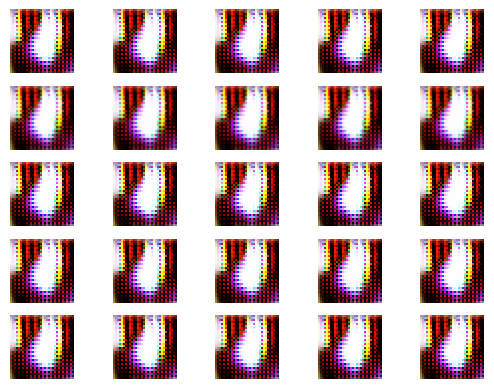

2/2 [==============================] - 0s 24ms/step
900 [D loss: 2.2413158416748047, acc.: 79.6875%] [G loss: 20.06443214416504]
1/1 [==============================] - 0s 44ms/step


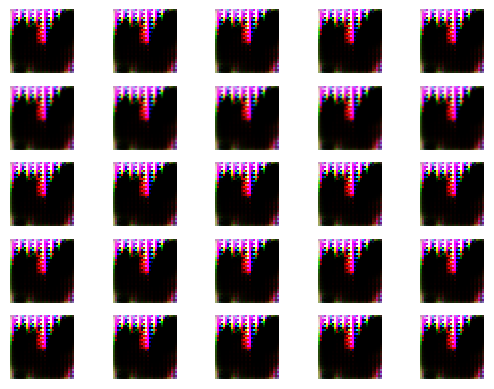

2/2 [==============================] - 0s 24ms/step


In [89]:
# Function to save generated images
def save_images(epoch, class_label):
    noise = np.random.normal(0, 1, (25, 100))  # Generate random noise
    labels = np.full((25, 1), class_label)  # Create an array of the class label

    # Generate images using the generator with noise and labels as input
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale from [-1, 1] to [0, 1]

    # Create a directory for saving images if it doesn't exist
    os.makedirs(f'generated_images/class_{class_label}', exist_ok=True)

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_images[cnt, :, :, :])  # Display generated images
            axs[i, j].axis('off')  # Turn off axes
            cnt += 1

    # Save the figure
    plt.savefig(f'generated_images/class_{class_label}/epoch_{epoch}.png', bbox_inches='tight')
    plt.show()
    plt.close(fig)  # Close the figure to free up memory


# Train the DCGAN
train(epochs=1000, batch_size=64, save_interval=100, class_label=1)

In [67]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

def preprocess_images(images):
    # Resize images to (299, 299)
    images_resized = tf.image.resize(images, (299, 299))
    # Scale pixel values to [0, 1] and apply InceptionV3 preprocessing
    images_resized = preprocess_input(images_resized)  # This also scales to [-1, 1]
    return images_resized

# Load InceptionV3 model
inception_model = InceptionV3(include_top=True, weights='imagenet')

def calculate_inception_score(images, splits=10):
    # Preprocess images for InceptionV3
    images = preprocess_images(images)  # Shape: (n_images, height, width, channels)

    # Get predictions
    preds = inception_model.predict(images)

    # Calculate mean and variance
    split_scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits)]
        py = np.mean(part, axis=0)  # Mean over the split
        scores = []
        for p in part:
            scores.append(np.exp(np.sum(p * np.log(p / py + 1e-10))))
        split_scores.append(np.mean(scores))

    return np.mean(split_scores), np.std(split_scores)

# Question 01

## **Modify the DCGAN to generate images for a specific class (e.g., cars, airplanes). Generate 10 examples of each class and analyze the quality and variety of the generated images.**

---

# Question 02

## **Apply data augmentation (random cropping, flipping, etc.) to the real CIFAR-10 images during discriminator training. Evaluate if augmentation improves the discriminator's performance and results in better-generated images.**

---

# Question 03

## **Implement the Inception Score to evaluate the quality of generated images. Train the DCGAN and compute the IS at various points (e.g., 2000, 5000, 10000 epochs). Compare the IS values with the visual quality of generated images.**

---

# Question 04

## **Add more layers to the generator and discriminator to create deeper models. Train the deeper DCGAN and observe if this complexity improves the quality of generated images.**



